# vim-emu evaluation for journal version of smoke testing paper

## Documentation to setup the experiments

### Branch
`son-emu` : `gh/paper2/evaluation`

### Error 'too many open files' during large experiments

Solution is to increase the `ulimit -n` (maximum number of open files) on the machine. Unfortunately, was not able to do this for a normal user on a Ubuntu 16.04. Only for the `root` user.

```sh
# switch to root
sudo su

# change sys. limit
vim /etc/sysctl.conf 
# add
fs.file-max = 2097152
# change limit for root user
ulimit -Sn 500000
ulimit -Hn 500000
# check
ulimit -a
# run your experiment using root
```


## TODO

- ~~Total setuptime (line, star mesh)~~
- ~~Memory usage~~
- ~~Setup time breakdown~~
- ~~Total setuptime TopologyZoo (time/memory)~~
- ~~Service deployment times (randomized deployment on TopologyZoo topos)~~



In [2]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.ticker as ticker

In [3]:
sns.set_style("ticks")
sns.set_context({"figure.figsize": (10, 5)})


## KPI SDK.3 (Testing environment setup time): Scaling Experiment

Start emulator platform with diffrent number of PoPs for `line`, `star`, and `mesh` topology.

Experiment execution:

* `sudo python examples/evaluation_starttimes.py --experiment scaling -r 10 --no-run`

AVG set up time for 1 PoP:
n_pops
1    3.812558
Name: time_total, dtype: float64


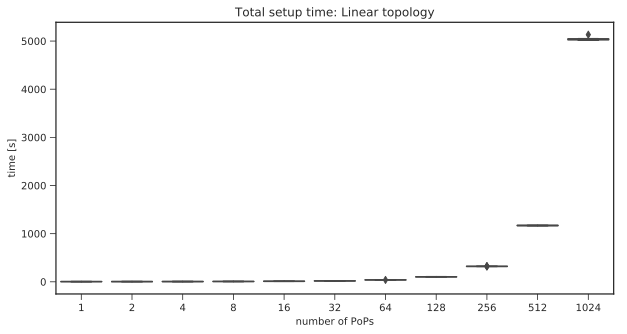

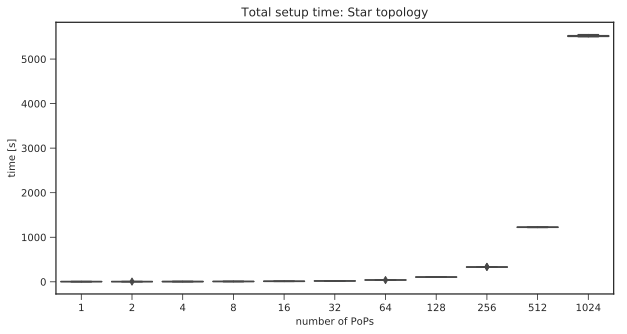

In [4]:
# read results
#df = pd.read_pickle("data/2017-12-05-scaling_experiment.pkl")
#df = pd.read_pickle("data/2018-08-03-tango1-scaling_experiment.pkl")
df = pd.read_pickle("data/2018-08-07-tango1-scaling_experiment_log.pkl")
#print(df)
df_line = df[df["topology"] == "line"]
df_star = df[df["topology"] == "star"]
#df_mesh = df[df["topology"] == "mesh"]

df_single = df_line[df_line["n_pops"]== 1]
df_single = df_single.groupby("n_pops").mean()
print("AVG set up time for 1 PoP:")
print(df_single["time_total"])

#df_line = df_line.groupby(["n_pops"]).mean()
#print(df_line)

def box_plot(d, x="n_pops", y="time_total", title="title", path="plots/boxplot.png"):
    plt.figure()
    ax = sns.boxplot(data=d, x="n_pops", y="time_total")
    ax.set_title(title)
    ax.set_xlabel("number of PoPs")
    ax.set_ylabel("time [s]")
    fig = ax.get_figure()
    fig.savefig(path, dpi=300)
    
box_plot(df_line, title="Total setup time: Linear topology", path="plots/sdk_emu_boxplot_total_line.png")
box_plot(df_star, title="Total setup time: Star topology", path="plots/sdk_emu_boxplot_total_star.png")
#box_plot(df_mesh, title="Total setup time: Mesh topology", path="plots/sdk_emu_boxplot_total_mesh.png")



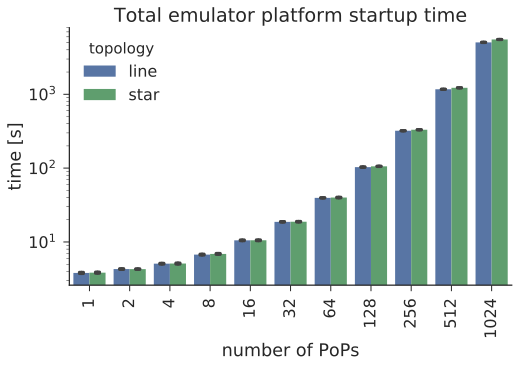

In [5]:
sns.set(font_scale=1.6)
sns.set_style("ticks")
#sns.set_palette("Blues", n_colors=3) # Greys, Blues_d
dff = df[df["topology"] != "mesh"].copy()
ax = sns.factorplot(x='n_pops',
                    y='time_total',
                    hue='topology',
                    data=dff,
                    kind="bar",
                    legend_out=False,
                    size=5.5,
                    aspect=1.4,
                    capsize=.1)
ax.set_xlabels("number of PoPs")
ax.set_xticklabels(rotation=90)
ax.set_ylabels("time [s]")
ax.fig.get_axes()[0].set_yscale('log', nonposy='clip')
plt.title("Total emulator platform startup time")
plt.tight_layout()
ax.savefig("plots/sdk_emu_startup_compare_line_star.png", dpi=300)
ax.savefig("plots/sdk_emu_startup_compare_line_star.pdf", dpi=300)

## KPI SDK.4 (Test platform scalability): Memory consumption

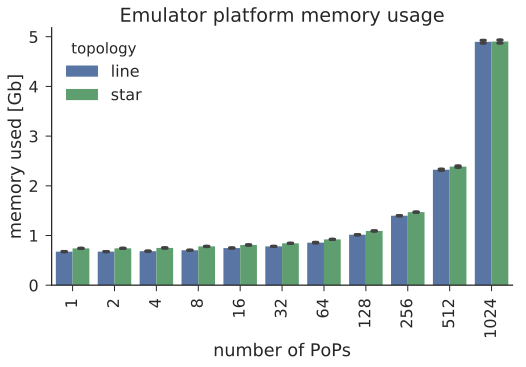

In [6]:
sns.set(font_scale=1.6)
sns.set_style("ticks")
#sns.set_palette("Blues", n_colors=3) # Greys, Blues_d
dff = df[df["topology"] != "mesh"].copy()
dff["mem_used"] = dff["mem_used"].map(lambda x: x / (1024 * 1024 * 1024))
#min_mem = dff["mem_used"].min() - 0.1
#dff["mem_used"] -= min_mem
ax = sns.factorplot(x='n_pops',
                    y='mem_used',
                    hue='topology',
                    data=dff,
                    kind="bar",
                    legend_out=False,
                    size=5.5,
                    aspect=1.4,
                    capsize=.1)
ax.set_xlabels("number of PoPs")
ax.set_ylabels("memory used [Gb]")
#ax.fig.get_axes()[0].set_yscale('log', nonposy='clip')
ax.set_xticklabels(rotation=90)
#ax.set(ylim=(0, 6.0))
plt.title("Emulator platform memory usage")
plt.tight_layout()
ax.savefig("plots/sdk_emu_mem_compare_line_star.png", dpi=300)
ax.savefig("plots/sdk_emu_mem_compare_line_star.pdf", dpi=300)

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f64a038f160> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6463cdb9b0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


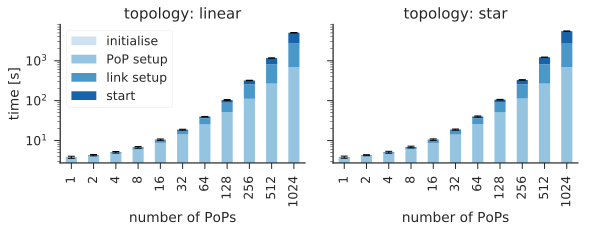

In [12]:
#df = pd.read_pickle("data/2017-12-05-scaling_experiment.pkl")
sns.set(font_scale=1.25)
sns.set_style("ticks", {'legend.frameon': True})
sns.set_palette("Blues", n_colors=4) # Greys, Blues_d

lbl_env_boot = "initialise"
lbl_pop_create = "PoP setup"
lbl_link_create = "link setup"
lbl_topo_start = "start"

dff = df.rename(columns={"time_env_boot": lbl_env_boot,
                        "time_pop_create": lbl_pop_create,
                        "time_link_create": lbl_link_create,
                        "time_topo_start": lbl_topo_start})
df_line = dff[dff["topology"] == "line"].groupby(["n_pops"]).mean()
std_line = dff[dff["topology"] == "line"].groupby(["n_pops"])["time_total"].std().reset_index()
df_line = df_line[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]
df_star = dff[dff["topology"] == "star"].groupby(["n_pops"]).mean()
std_star = dff[dff["topology"] == "star"].groupby(["n_pops"])["time_total"].std().reset_index()
df_star = df_star[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]
#df_mesh = dff[dff["topology"] == "mesh"].groupby(["n_pops"]).mean()
#df_mesh = df_mesh[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]

#ticklabels = [1]
#ticklabels += [i if (i % 10 == 0) else "" for i in range(5, 101, 5)]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(8.5, 3.5)

# calculate totals for error bar plot overlay
sum_line = df_line[lbl_env_boot] + df_line[lbl_pop_create] + df_line[lbl_link_create] + df_line[lbl_topo_start]
sum_line = sum_line.reset_index()
sum_line = sum_line.drop("n_pops", axis=1)
sum_line = sum_line.rename(columns={0: "_nolegend_"})

sum_star = df_star[lbl_env_boot] + df_star[lbl_pop_create] + df_star[lbl_link_create] + df_star[lbl_topo_start]
sum_star = sum_star.reset_index()
sum_star = sum_star.drop("n_pops", axis=1)
sum_star = sum_star.rename(columns={0: "_nolegend_"})

df_line.plot(ax=ax1, kind="bar", stacked=True)
sum_line.plot(ax=ax1, yerr=list(std_line["time_total"]*2.0), linewidth=0.0, elinewidth=1.0, color="black", **{"capsize": 3.5, "capthick": 1.0})
df_star.plot.bar(ax=ax2, stacked=True)
sum_star.plot(ax=ax2, yerr=list(std_star["time_total"]*2.0), linewidth=0.0, elinewidth=1.0, color="black", **{"capsize": 3.5, "capthick": 1.0})
#df_mesh.plot.bar(ax=ax3, stacked=True)
sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)
#sns.despine(ax=ax3, top=True, right=True, left=False, bottom=False)
ax1.set_xlabel("number of PoPs")
ax2.set_xlabel("number of PoPs")
#ax3.set_xlabel("number of PoPs")
ax1.set_ylabel("time [s]")
#ax2.set_ylabel("time [s]")
#ax3.set_ylabel("time [s]")
f.get_axes()[0].set_yscale('log', nonposy='clip')
ax1.legend().set_visible(True)
ax2.legend().set_visible(False)
#ax3.legend().set_visible(False)
#ax1.axes.xaxis.set_ticklabels(ticklabels)
#ax2.axes.xaxis.set_ticklabels(ticklabels)
#ax3.axes.xaxis.set_ticklabels(ticklabels)
ax1.set_title("topology: linear")
ax2.set_title("topology: star")
#ax3.set_title("topology: mesh")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
f.tight_layout()
f.savefig("plots/sdk_emu_startup_breakdown.png", dpi=300)
f.savefig("plots/sdk_emu_startup_breakdown.pdf", dpi=300)

## KPI SDK.3 (Testing environment setup time): TopologyZoo Experiment

Experiment execution:

* `* sudo python examples/evaluation_starttimes.py --experiment zoo -r 10 --no-run`

In [ ]:
# read results
df2 = pd.read_pickle("data/2017-12-08-topologyzoo-5rep.pkl")
#print(df2["time_env_boot"])
filter_list = ["Abilene",
               "Arpanet196912",
               "Arpanet19728",
              "AsnetAm",
              "Basnet",
              "Belnet2010",
              "BtNorthAmerica",
              "BtLatinAmerica",
              "BtEurope",
              "BtAsiaPac",
              "Chinanet",
              "DeutscheTelekom",
              "Dfn",
              "Geant2012",
              "Globenet",
              "Interoute",
               "Ion",
              "LambdaNet",
               "Oxford",
               "Telcove",
               "Telecomserbia",
               "UsCarrier"
              ]
lbl_env_boot = "environment boot"
lbl_pop_create = "PoP setup"
lbl_link_create = "connection setup"
lbl_topo_start = "platform start"

dff = df2.rename(columns={"time_env_boot": lbl_env_boot,
                        "time_pop_create": lbl_pop_create,
                        "time_link_create": lbl_link_create,
                        "time_topo_start": lbl_topo_start})
dff = dff[dff["topology"].isin(filter_list)].groupby(["topology"]).mean()

#print(dff)

dff = dff[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]



f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(8, 6)
#ax.set_yscale('log', nonposy='clip')
#ax.set_xscale('log', nonposx='clip')
ax = dff.plot.barh(ax=ax, stacked=True)
ax.set_xlabel("time [s]")
ax.set_ylabel("Topology")
ax.set_title("Emulation platform setup times for real-world topologies")
plt.tight_layout()
plt.savefig("plots/sdk_emu_startup_topologyzoo_selected.png", dpi=300)
plt.savefig("plots/sdk_emu_startup_topologyzoo_selected.pdf", dpi=300)

In [ ]:
# read results
df2 = pd.read_pickle("data/2017-12-08-topologyzoo-5rep.pkl")
#print(df2["time_env_boot"])
filter_list = ["Abilene",
               "Arpanet196912",
               "Arpanet19728",
              "AsnetAm",
              "Basnet",
              "Belnet2010",
              "BtNorthAmerica",
              "BtLatinAmerica",
              "BtEurope",
              "BtAsiaPac",
              "Chinanet",
              "DeutscheTelekom",
              "Dfn",
              "Geant2012",
              "Globenet",
              "Interoute",
               "Ion",
              "LambdaNet",
               "Oxford",
               "Telcove",
               "Telecomserbia",
               "UsCarrier"
              ]

dff = df2[df2["topology"].isin(filter_list)].groupby(["topology"]).mean()
dff = dff[["mem_used"]]
dff["mem_used"] = dff["mem_used"].map(lambda x: x / (1024 * 1024 * 1024))

f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(8, 6)
#ax.set_yscale('log', nonposy='clip')
#ax.set_xscale('log', nonposx='clip')
ax = dff.plot.barh(ax=ax, stacked=False, legend=False)
ax.set_xlim(9, 10)
ax.set_xlabel("Memory used [Gb]")
ax.set_ylabel("Topology")
ax.set_title("Emulation platform memory usage for real-world topologies")
plt.tight_layout()
plt.savefig("plots/sdk_emu_memory_topologyzoo_selected.png", dpi=300)
plt.savefig("plots/sdk_emu_memory_topologyzoo_selected.pdf", dpi=300)

## KPI SDK.4 (Test platform scalability): Time required to start NS (TopoZoo)

Experiment execution:

* `sudo python examples/evaluation_starttimes.py --experiment service2 -r 5 --no-run`

In [ ]:
df = pd.read_pickle("data/2017-12-09-service-start-topozoo.pkl")

# add node and link numbers
data = df.to_dict('records')
for r in data:
    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
df = pd.DataFrame(data)

sns.set(font_scale=1.6)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d

ax = sns.factorplot(x='service_size',
                    y='time_service_start',
                    hue='topology',
                    data=df,
                    kind="bar",
                    legend_out=False,
                    size=5.5,
                    aspect=1.4,
                    capsize=.1)
ax.fig.get_axes()[0].set_yscale('log', nonposy='clip')
ax.set_xlabels("number of deployed VNFs")
ax.set_ylabels("time [s]")
plt.title("emulator service start times")
plt.tight_layout()
ax.savefig("plots/sdk_emu_service_start_time.png", dpi=300)
ax.savefig("plots/sdk_emu_service_start_time.pdf", dpi=300)

## KPI SDK.5 (Test platform scalability): Time required to start NS (line, mesh, star)

Experiment execution:

* `sudo python examples/evaluation_starttimes.py --experiment service -r 10 --no-run`

In [ ]:
df = pd.read_pickle("data/2018-01-24-service-start-linear-star-mesh.pkl")

# add node and link numbers
#data = df.to_dict('records')
#for r in data:
#    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
#df = pd.DataFrame(data)

sns.set(font_scale=1.6)
sns.set_style("ticks")
#sns.set_palette("Blues", n_colors=3) # Greys, Blues_d

ax = sns.factorplot(x='service_size',
                    y='time_service_start',
                    hue='topology',
                    data=df,
                    kind="bar",
                    legend_out=False,
                    size=5.5,
                    aspect=1.4,
                    capsize=.1)
ax.fig.get_axes()[0].set_yscale('log', nonposy='clip')
ax.set_xlabels("number of deployed VNFs")
ax.set_ylabels("time [s]")
plt.title("emulator service start times")
plt.tight_layout()
ax.savefig("plots/sdk_emu_service_start_time2.png", dpi=300)
ax.savefig("plots/sdk_emu_service_start_time2.pdf", dpi=300)

## OSM VIM Setup Time Experiment

** Attention: OSM VIM list has a bug since the SO does not support to set a query limit. RO uses 100 per default. As a results, services can only be started on the first 100 PoPs **

Hardcoded limit: https://osm.etsi.org/gitweb/?p=osm/RO.git;a=blob;f=osm_ro/httpserver.py;h=0497bbacc9b4efd387ddcb896aef6fa591c1d6b3;hb=HEAD Line 277


In [ ]:
df1 = pd.read_pickle("data/2017-12-19-osm_zoo_setup_result.pkl")
df2 = pd.read_pickle("data/2017-12-19-osm_zoo_setup_osm_result.pkl")
df3 = df2[df2["action"] == "vim-create"].groupby(["topology"]).mean()
df4 = df2[df2["action"] == "vim-create"].groupby(["topology", "r_id"])['time_action'].sum()
df5 = df4.groupby(["topology"]).mean()
#print(df1)
#print(df4)
print(df5)

#df4 = df4[["time"]]

f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(8, 6)
#ax.set_yscale('log', nonposy='clip')
#ax.set_xscale('log', nonposx='clip')
ax = df5.plot.barh(ax=ax, stacked=False, legend=False, color="darkblue")
#ax.set_xlim(9, 10)
ax.set_xlabel("time [s]")
ax.set_ylabel("Topology")
ax.set_title("OSM total VIM creation times")
plt.tight_layout()
plt.savefig("plots/osm_emu_total_vim_create_time.png", dpi=300)
plt.savefig("plots/osm_emu_total_vim_create_time.pdf", dpi=300)


In [ ]:
# read results
df = pd.read_pickle("data/2017-12-19-osm_zoo_setup_osm_result.pkl")

#
data = df.to_dict('records')
for r in data:
    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
df = pd.DataFrame(data)

# sum up vim-create commands
df_vim = df[df["action"] == "vim-create"].groupby(["topology", "r_id"]).sum()
df_vim = df_vim.groupby(["topology"]).mean()

lbl_env_boot = "emulator initialization"
lbl_pop_create = "emulator PoP setup"
lbl_link_create = "emulator link setup"
lbl_topo_start = "emulator start"
lbl_vim_create = "osm vim-create"

dff = df.groupby(["topology"]).mean()
# combine summed dataframe and simple dataframe
dff = pd.merge(df_vim, dff, how='outer', left_index=True, right_index=True)
dff = dff.rename(columns={"time_env_boot_y": lbl_env_boot,
                        "time_pop_create_y": lbl_pop_create,
                        "time_link_create_y": lbl_link_create,
                        "time_topo_start_y": lbl_topo_start,
                         "time_action_x": lbl_vim_create})

print(list(dff))
# sort
dff = dff.sort_values(by=["n_pops_y"], ascending=False)
# select columns to show
dff = dff[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start, lbl_vim_create]]

f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(10, 5)
#ax.set_yscale('log', nonposy='clip')
#ax.set_xscale('log', nonposx='clip')
ax = dff.plot.barh(ax=ax, stacked=True)
ax.set_xlabel("time [s]")
ax.set_ylabel("Topology")
ax.set_title("Emulation platform startup times for real-world topologies")
plt.tight_layout()
plt.savefig("plots/osm_emu_total_vim_create_time_all.png", dpi=300)
plt.savefig("plots/osm_emu_total_vim_create_time_all.pdf", dpi=300)

### Double plot with normalized osm-create values

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=5) # Greys, Blues_d

# read results
df = pd.read_pickle("data/2017-12-19-osm_zoo_setup_osm_result.pkl")

#
data = df.to_dict('records')
for r in data:
    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
df = pd.DataFrame(data)

# sum up vim-create commands
df_vim = df[df["action"] == "vim-create"].groupby(["topology", "r_id"]).sum()
df_vim = df_vim.groupby(["topology"]).mean()

lbl_env_boot = "emu. initialise"
lbl_pop_create = "emu. PoP setup"
lbl_link_create = "emu. link setup"
lbl_topo_start = "emu. start"
lbl_vim_create = "osm vim-create"

dff = df.groupby(["topology"]).mean()
# combine summed dataframe and simple dataframe
dff = pd.merge(df_vim, dff, how='outer', left_index=True, right_index=True)
dff = dff.rename(columns={"time_env_boot_y": lbl_env_boot,
                        "time_pop_create_y": lbl_pop_create,
                        "time_link_create_y": lbl_link_create,
                        "time_topo_start_y": lbl_topo_start,
                         "time_action_x": lbl_vim_create})

print(list(dff))

# generate normalized osm vim-create values
df_vim2 = df.copy()
df_vim2 = df_vim2[df_vim2["action"] == "vim-create"]#.groupby(["topology", "r_id"]).mean()
#df_vim2["time_action"] /= df_vim2["n_pops"]

#df_vim2[df_vim2["action"] == "vim-create"].groupby(["topology", "r_id"]).mean()

#print(df_vim2)

# sort
dff = dff.sort_values(by=["n_pops_y"], ascending=False)
# select columns to show
dff = dff[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start, lbl_vim_create]]

f, ax = plt.subplots(1, 2, sharey=False, gridspec_kw = {'width_ratios':[5, 3]})
f.set_size_inches(8, 5) # set width 7 for paper



for i in range(0, 2):
    #ax.set_yscale('log', nonposy='clip')
    #ax.set_xscale('log', nonposx='clip')
    if i == 0:
        dff.plot.barh(ax=ax[i], stacked=True)
        
        # fill with patterns for printing
        #bars = ax[i].patches
        #hatches = ["//", "\\", "**", "o", ".."] * 22
        #for b, h in zip(bars, hatches):
        #    b.set_hatch(h)
        
        ax[i].set_xlabel("time [s]")
        ax[i].set_ylabel("topology")
        ax[i].set_title("total setup times")
    else:  
        df_vim2 = df_vim2.sort_values(by=["n_pops"], ascending=True).copy()
        sns.boxplot(ax=ax[i], data=df_vim2, y="topology", x="time_action", orient="h", color="#569DCB", linewidth=1.0, fliersize=3.0)
        ax[i].set_title("'vim-create'\nrequest times")
        ax[i].set_xlabel("time/request [s]")
        ax[i].set_xlim(0.46, 0.60)
        ax[i].get_yaxis().set_visible(False)  # sharing Y axis does not work so we need to hide it!
f.tight_layout()
plt.savefig("plots/osm_emu_total_vim_create_time_all2.png", dpi=300)
plt.savefig("plots/osm_emu_total_vim_create_time_all2.pdf", dpi=300)

In [ ]:
def plot_cdf(ax, d_in, col="time_action", *args, **kwargs):
    d_in = d_in.copy()
    samples = list(d_in[col].tolist())
    samples_sorted = np.sort(samples)
    yvals = np.arange(len(samples_sorted))/float(len(samples_sorted)) 
    ax.step(samples_sorted, yvals, *args, **kwargs)

def plot_cdf_binned(ax, d_in, bins=50, col="time_action", *args, **kwargs):
    d_in = d_in.copy()
    samples = list(d_in[col].tolist())
    counts, bins = np.histogram(samples, bins=bins)
    cdf = np.cumsum(counts)/np.sum(counts) 
    ax.plot(np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
            np.vstack((cdf, cdf)).T.flatten(),
            *args, **kwargs)

In [ ]:
df1 = pd.read_pickle("data/2017-12-19-osm_zoo_setup_result.pkl")
df2 = pd.read_pickle("data/2017-12-19-osm_zoo_setup_osm_result.pkl")
df3 = df2[["action", "topology", "time_action"]]

topos = list(set(df3["topology"].values.tolist()))
topos = ['Abilene', 'DeutscheTelekom', 'UsCarrier']
actions = ["vim-create", "vim-show", "vim-delete"]
titles = ["'osm vim-create' response times", "'osm vim-show' response times", "'osm vim-delete' response times"]

f, axs = plt.subplots(1, 3, sharey=False)
f.set_size_inches(12, 6)

for i in range(0, 3):
    ax = axs[i]
    for t in topos:
        dff = df3[(df3["topology"] == t) & (df3["action"] == actions[i])]
        plot_cdf_binned(ax, dff, bins=150, label=t, lw=1.5)
    #ax.set_xlim(0.47, 0.57)
    ax.set_ylim(0, 1)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("ECDF")
    ax.set_title(titles[i])
plt.legend()
plt.tight_layout()
plt.savefig("plots/osm_emu_cdf_vim_create_time.png", dpi=300)
plt.savefig("plots/osm_emu_cdf_vim_create_time.pdf", dpi=300)

## OSM Service Deployment

ping pong service on two different topologies

action==ns-create?
time_action?

it is in time_service_start
ns_running  

Check experiment code to get the deployment times of the services.
Scatter plot? X = n_services running, Y = total deployment time or deployment time of next service?


In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks", {'legend.frameon': True})
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d

def load_multi_df():
    paths = ["data/2018-01-15-OsmService64/Abilene_r1.pkl",
            "data/2018-01-15-OsmService64/Abilene_r2.pkl",
            "data/2018-01-15-OsmService64/Abilene_r3.pkl",
            "data/2018-01-15-OsmService64/Abilene_r4.pkl",
            "data/2018-01-15-OsmService64/Abilene_r5.pkl",
            "data/2018-01-15-OsmService64/DeutscheTelekom_r1.pkl",
            "data/2018-01-15-OsmService64/DeutscheTelekom_r2.pkl",
            "data/2018-01-15-OsmService64/DeutscheTelekom_r3.pkl",
            "data/2018-01-15-OsmService64/DeutscheTelekom_r4.pkl",
            "data/2018-01-15-OsmService64/DeutscheTelekom_r5.pkl",
            "data/2018-01-15-OsmService64/UsCarrier_r1.pkl",
            "data/2018-01-15-OsmService64/UsCarrier_r2.pkl",
            "data/2018-01-15-OsmService64/UsCarrier_r3.pkl",
            "data/2018-01-15-OsmService64/UsCarrier_r4.pkl",
            "data/2018-01-15-OsmService64/UsCarrier_r5.pkl"]
    df = pd.concat([pd.read_pickle(p) for p in paths])
    return df

df = load_multi_df()

df1 = df[(df["action"] == "ns-create") & (df["topology"] == "Abilene")]
df2 = df[(df["action"] == "ns-create") & (df["topology"] == "DeutscheTelekom")]
df3 = df[(df["action"] == "ns-create") & (df["topology"] == "UsCarrier")]

#print(df3)
#print(df1[["action", "ns_running", "time_action"]])
palette = itertools.cycle(sns.color_palette())
f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(8, 2.4)
df1.plot.scatter(ax=ax, x="ns_running", y="time_action", label="Abilene", color=next(palette))
df2.plot.scatter(ax=ax, x="ns_running", y="time_action", label="DeutscheTelekom", color=next(palette))
df3.plot.scatter(ax=ax, x="ns_running", y="time_action", label="UsCarrier", color=next(palette))
ax.set_title("'ns-create' requests times")
ax.set_xlabel("running network services")
ax.set_ylabel("time [s]")
plt.tight_layout()
plt.savefig("plots/osm_emu_scatter_ns_create_time.png", dpi=300)
plt.savefig("plots/osm_emu_scatter_ns_create_time.pdf", dpi=300)

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d
df = load_multi_df()
df = df[(df["action"] == "ns-create")]
df = df[(df["ns_running"].isin([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]))]

f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(10, 5)
ax = sns.boxplot(ax=ax, x="ns_running", y="time_action", hue="topology", data=df)

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d

df1 = pd.read_pickle("data/2017-12-22-osm_zoo_service_abilene_64_osm_result.pkl")
df2 = pd.read_pickle("data/2017-12-22-osm_zoo_service_deutschetelekom_64_osm_result.pkl")

df = load_multi_df()

# add node and link numbers
#data = df.to_dict('records')
#for r in data:
#    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
#df = pd.DataFrame(data)

#print(df)
#print(df[["time_service_start"]])

dfc = df[df["action"] == "ns-create"]
dfd = df[df["action"] == "ns-delete"]

#print(dfd)

f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(8, 1.8)
sns.boxplot(ax=axs[0], data=dfc, y="topology", x="time_action", orient="h", linewidth=1.0, fliersize=3.0)
axs[0].set_title("'ns-create'")
axs[0].set_xlabel("time/request [s]")
axs[0].set_ylabel("")
axs[0].set_xlim(5, 25)
axs[0].get_yaxis().set_visible(True)  
sns.boxplot(ax=axs[1], data=dfd, y="topology", x="time_action", orient="h", linewidth=1.0, fliersize=3.0)
axs[1].set_title("'ns-delete'")
axs[1].set_xlabel("time/request [s]")
axs[1].set_ylabel("")
axs[1].set_xlim(0, 25)
axs[1].get_yaxis().set_visible(False)  
#f.subplots_adjust(bottom = 0)
#f.subplots_adjust(top = 1)
#f.subplots_adjust(right = 1)
#f.subplots_adjust(left = -1)
plt.tight_layout()
plt.savefig("plots/osm_emu_box_ns_create_delete_time.png", dpi=300)
plt.savefig("plots/osm_emu_box_ns_create_delete_time.pdf", dpi=300)